In [1809]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch import tensor, Tensor

In [1810]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
INIT_LEARNING_RATE = 0.025
MIN_LR_RATE = 0.5

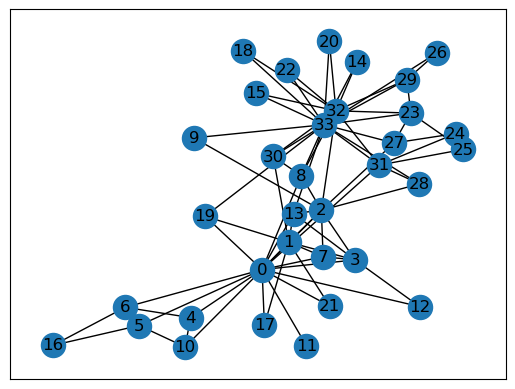

In [1811]:
# Load dataset
g: nx.Graph = nx.karate_club_graph()
vertices = list(g)
V = len(g)
nx.draw_networkx(g)

In [1812]:
def random_walk(v):
    # walk bắt đầu từ v
    walk = [v]
    for i in range(WALK_LENGTH - 1):
        # chọn đỉnh kề ngẫu nhiên
        next_node = random.choice(list(g[v]))
        # thêm đỉnh kề vào walk
        walk.append(next_node)
        # nhảy tới đỉnh kề
        v = next_node
    return walk

In [1813]:
class NeighborPrediction(nn.Module):
    def __init__(self) -> None:
        super(NeighborPrediction, self).__init__()
        # Hidden layer biểu diễn vector cho đỉnh
        self.embedding_layer = nn.Embedding(num_embeddings=V, embedding_dim=EMBEDDING_SIZE)
        
        # Biểu diễn T bằng complete binary tree đếm từ 0
        # Luôn biểu diễn được T sao cho số lá tầng cuối = chẵn
        # <=> số nút trong = số nút lá (tức V) - 1
        self.inner_nodes_cnt = V - 1
        # Output layer (các nút trong của T) cho hierarchical softmax
        self.hsoftmax_layer = nn.Parameter(torch.rand((self.inner_nodes_cnt, EMBEDDING_SIZE)))
    
    def forward(self, u, v):
        '''Đoán xác xuất Pr(u | v_emb)'''
        p = tensor(1.0)
        
        # Lấy ra biểu diễn vector của v
        v_emb = self.embedding_layer(tensor(v))
        
        # Tính nút lá ứng với u trong cây nhị phân T
        node = self.inner_nodes_cnt + u
        
        while node:
            # Kiểm tra nút hiện tại là con trái hay phải
            isLeftChild = node & 1
            
            # Nhảy lên nút cha
            if isLeftChild:
                node >>= 1
            else:
                node = node - 1 >> 1
            
            # Lấy ra biểu diễn vector của nút trong
            node_emb = self.hsoftmax_layer[tensor(node)]

            # Tính Pr(node -> u | v_emb) rồi cập nhật Pr(u | v_emb)
            if isLeftChild:
                p *= torch.sigmoid(node_emb.dot(v_emb))
            else:
                p *= tensor(1) - torch.sigmoid(node_emb.dot(v_emb))
        return p
    

In [1814]:
model = NeighborPrediction()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=INIT_LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=MIN_LR_RATE,
    total_iters=WALKS_PER_VERTEX
)
loss_records = []

In [1815]:
def skip_gram(walk: list):
    running_loss = 0.0
    cnt = 0
    w = random.randint(1, WINDOW_SIZE)
    for j, v in enumerate(walk):
        window = walk[j - w : j]
        window.extend(walk[j + 1 : j + w + 1])
        for u in window:
            # reset gradient về 0
            optimizer.zero_grad()
            # Pr(u | v_emb)
            p = model(u, v)
            # tính hàm mất mát
            loss = torch.log(p) * tensor(-1)
            # lan truyền ngược để tính gradient cho các parameter
            loss.backward()
            # tối ưu các parameter với gradient tính đc
            optimizer.step()
            
            # Ghi nhận lại hàm mất mát
            running_loss += loss.item()
            cnt += 1
    return (running_loss, cnt)

In [1816]:
for i in range(WALKS_PER_VERTEX):
    epoch_loss = 0.0
    cnt = 0
    random.shuffle(vertices)
    for src in vertices:
        # lấy ra đường đi ngẫu nhiên
        walk = random_walk(src)
        # huấn luyện skipgram
        (running_loss, running_cnt) = skip_gram(walk)
        # Ghi nhận lại hàm mất mát
        epoch_loss += running_loss
        cnt += running_cnt
        
    # tính trung bình hàm mất mát cho lần chạy
    loss_records.append(epoch_loss / cnt)
    
    # Giảm tuyến tính tỉ lệ học
    lr_scheduler.step()

Text(0.5, 1.0, 'Hàm mất mát theo thời gian')

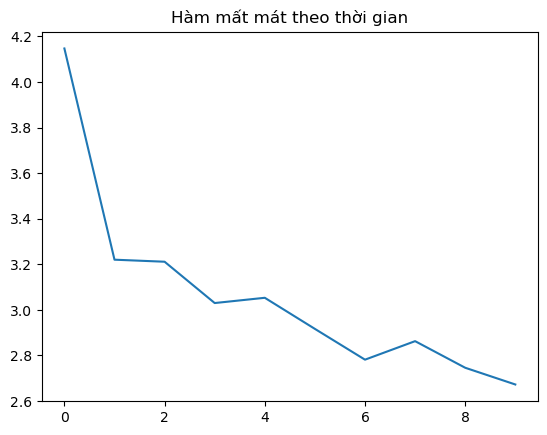

In [1817]:
plt.tick_params('y')
plt.plot(loss_records)
plt.title("Hàm mất mát theo thời gian")

In [1833]:
# pos = {v: v_emb.tolist() for v, v_emb in enumerate(model.embedding_layer(tensor(list(g))))}
# nx.draw_networkx(g, pos)
print(model(0,17))

tensor(0.4741, grad_fn=<MulBackward0>)
